# XGBoost

In this notebook we tried using XGBoost to predict the weather data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import xgboost as xgb
import optuna

/Users/nataliiaremezova/Documents/Workspace/BHT/SoSe2025/DSApps2/repo_copy/BerlinWeatherTimeSeriesAnalysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read in & Preprocess data

In [2]:
years = ['2023', '2024']
columns = ['ISO Time','Temperature (C)','Humidity (%)','Pressure (kPa)','Air Quality (Ohms)']
raw = pd.concat([pd.read_csv(f'../data/{y}_BME680SensorData.csv', usecols=columns, parse_dates=['ISO Time']) for y in years], ignore_index=True)
raw = raw.set_index('ISO Time').sort_index()


full_idx = pd.date_range(start=raw.index.min(), end=raw.index.max(), freq='T')
raw = raw.reindex(full_idx)

print('### Before imputation ###')
print(raw.isna().sum(), '')

def impute_neighbor_avg(s): return s.where(s.notna(), (s.shift(1)+s.shift(-1))/2).ffill().bfill()
for c in columns[1:]: raw[c]=impute_neighbor_avg(raw[c])
print('### After imputation ###')
print(raw.isna().sum(), '')

hourly = raw.resample('h').mean()
print('### Hourly-averaged preview ###')
print(hourly.head(), '')
print(hourly.isna().sum())

### Before imputation ###
Temperature (C)       289703
Humidity (%)          289703
Pressure (kPa)        289703
Air Quality (Ohms)    289703
dtype: int64 
### After imputation ###
Temperature (C)       0
Humidity (%)          0
Pressure (kPa)        0
Air Quality (Ohms)    0
dtype: int64 
### Hourly-averaged preview ###
                     Temperature (C)  Humidity (%)  Pressure (kPa)  \
2023-01-01 00:00:00        16.246667     65.615833      100.391983   
2023-01-01 01:00:00        16.208250     62.545417      100.420300   
2023-01-01 02:00:00        16.214583     60.435417      100.429167   
2023-01-01 03:00:00        16.014083     60.392000      100.426317   
2023-01-01 04:00:00        15.749667     61.041250      100.478783   

                     Air Quality (Ohms)  
2023-01-01 00:00:00       320226.233333  
2023-01-01 01:00:00       378913.650000  
2023-01-01 02:00:00       455404.975000  
2023-01-01 03:00:00       502504.808333  
2023-01-01 04:00:00       516891.291667   
Tem

/var/folders/7r/8tzl4xz922146pgx3szt94t80000gn/T/ipykernel_28221/1480128191.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_idx = pd.date_range(start=raw.index.min(), end=raw.index.max(), freq='T')


Plot Data

<Figure size 1400x500 with 0 Axes>

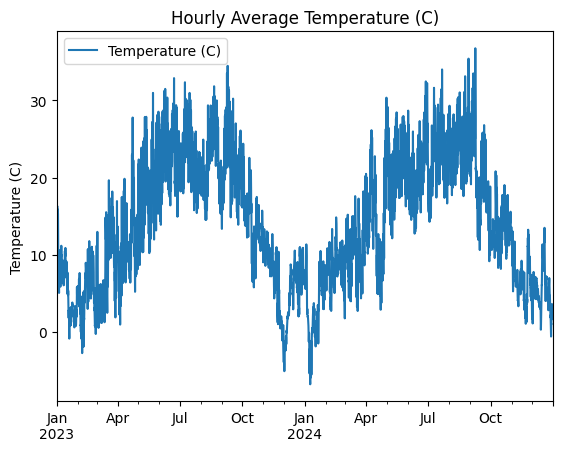

<Figure size 1400x500 with 0 Axes>

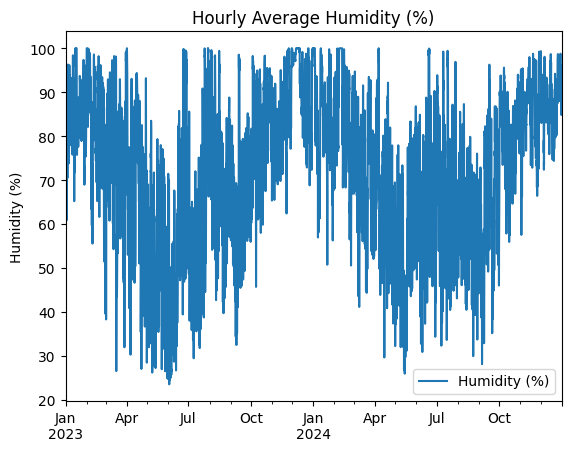

<Figure size 1400x500 with 0 Axes>

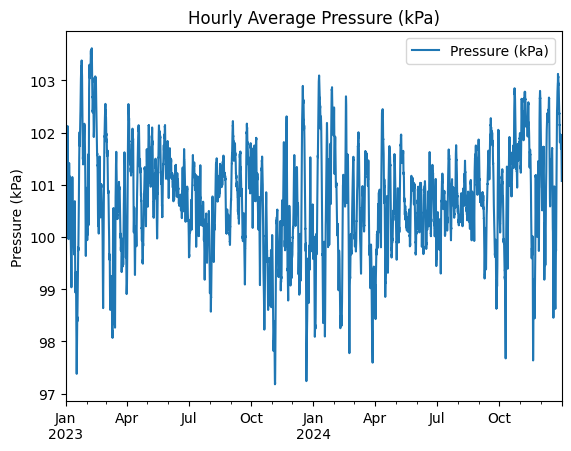

<Figure size 1400x500 with 0 Axes>

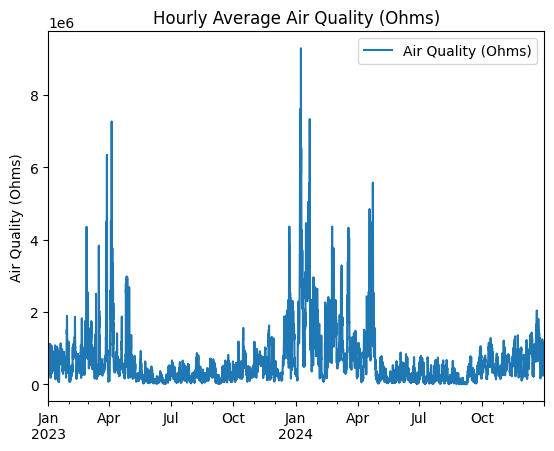

In [3]:
var_names = columns[1:]

for variable in var_names:
    plt.figure(figsize=(14, 5))
    hourly.plot(y=variable)
    plt.title(f"Hourly Average {variable}")
    plt.ylabel(variable)
    plt.show()

In [4]:
train_data = hourly["Temperature (C)"].dropna().to_numpy()

look_back = 168  # 7 days
horizon = 24     # 1 day

In [5]:
# Load raw 2025 data
test_df = (
    pd.read_csv("../data/2025_BME680SensorData.csv",
                usecols=columns,
                parse_dates=["ISO Time"])
      .set_index("ISO Time")
)

full_idx_test = pd.date_range(test_df.index.min(), test_df.index.max(), freq="T")
test_df = test_df.reindex(full_idx_test)

for col in columns[1:]:
    test_df[col] = impute_neighbor_avg(test_df[col])

hourly_test = test_df.resample("H").mean()


/var/folders/7r/8tzl4xz922146pgx3szt94t80000gn/T/ipykernel_28221/126540297.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_idx_test = pd.date_range(test_df.index.min(), test_df.index.max(), freq="T")
/var/folders/7r/8tzl4xz922146pgx3szt94t80000gn/T/ipykernel_28221/126540297.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_test = test_df.resample("H").mean()


CV HPO

In [ ]:
look_back = 168   # use last 7 days
horizon   = 24    # predict 1 day ahead

def create_supervised(df, look_back, horizon):
    data = {}
    # target
    data['target'] = df['Temperature (C)'].shift(-horizon)
    # all lags
    for i in range(1, look_back+1):
        data[f'lag_{i}'] = df['Temperature (C)'].shift(i)
    # now make one clean DataFrame
    df_feat = pd.DataFrame(data).dropna()
    X = df_feat[[f'lag_{i}' for i in range(1, look_back+1)]]
    y = df_feat['target']
    return X, y

X_train, y_train = create_supervised(hourly, look_back, horizon)
X_test,  y_test  = create_supervised(hourly_test, look_back, horizon)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (17352, 168) Test size: (3733, 168)


In [8]:
def objective(trial):
    params = {
        "n_estimators":     trial.suggest_int("n_estimators",  50, 500),
        "learning_rate":    trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "max_depth":        trial.suggest_int("max_depth",      3, 10),
        "subsample":        trial.suggest_float("subsample",   0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        **params
    )
    cv = TimeSeriesSplit(n_splits=5)
    # negative MSE → get RMSE
    neg_mses = cross_val_score(
        model, X_train, y_train,
        cv=cv,
        scoring="neg_mean_squared_error",
        n_jobs=1
    )
    rmses = np.sqrt(-neg_mses)
    return float(rmses.mean())

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)


[I 2025-07-11 00:42:20,409] A new study created in memory with name: no-name-f26ef62b-c467-4437-9d3a-049594509754


[I 2025-07-11 00:42:57,648] Trial 0 finished with value: 4.3863695514867205 and parameters: {'n_estimators': 427, 'learning_rate': 0.020372361478668, 'max_depth': 9, 'subsample': 0.7609555979944196, 'colsample_bytree': 0.8379910463321203}. Best is trial 0 with value: 4.3863695514867205.
[I 2025-07-11 00:43:13,777] Trial 1 finished with value: 9.121884923477557 and parameters: {'n_estimators': 429, 'learning_rate': 0.00014573423368686682, 'max_depth': 7, 'subsample': 0.8782448104065588, 'colsample_bytree': 0.5508196322509609}. Best is trial 0 with value: 4.3863695514867205.
[I 2025-07-11 00:43:21,927] Trial 2 finished with value: 9.157968499539177 and parameters: {'n_estimators': 83, 'learning_rate': 0.0006837152885378926, 'max_depth': 9, 'subsample': 0.91901207022086, 'colsample_bytree': 0.5321269587987789}. Best is trial 0 with value: 4.3863695514867205.
[I 2025-07-11 00:43:25,848] Trial 3 finished with value: 9.267657382392322 and parameters: {'n_estimators': 208, 'learning_rate': 0.

Best hyperparameters: {'n_estimators': 385, 'learning_rate': 0.06330183649022206, 'max_depth': 3, 'subsample': 0.6485501010561864, 'colsample_bytree': 0.6868052410988811}


In [9]:
def mean_absolute_scaled_error(y_true, y_pred, insample):
    """ MASE using naive forecast as denominator (seasonality=1 assumed) """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    insample = np.array(insample)
    naive_forecast = np.abs(insample[1:] - insample[:-1])
    denom = np.mean(naive_forecast)
    return np.mean(np.abs(y_true - y_pred)) / denom

In [10]:
best_params = study.best_params
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    **best_params
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mase = mean_absolute_scaled_error(
    y_true=y_test,
    y_pred=y_pred,
    insample=y_train
)

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.3f}")
print(f"MASE: {mase:.3f}")


MAPE: 108.75%
RMSE: 2.724
MASE: 4.910


Plots

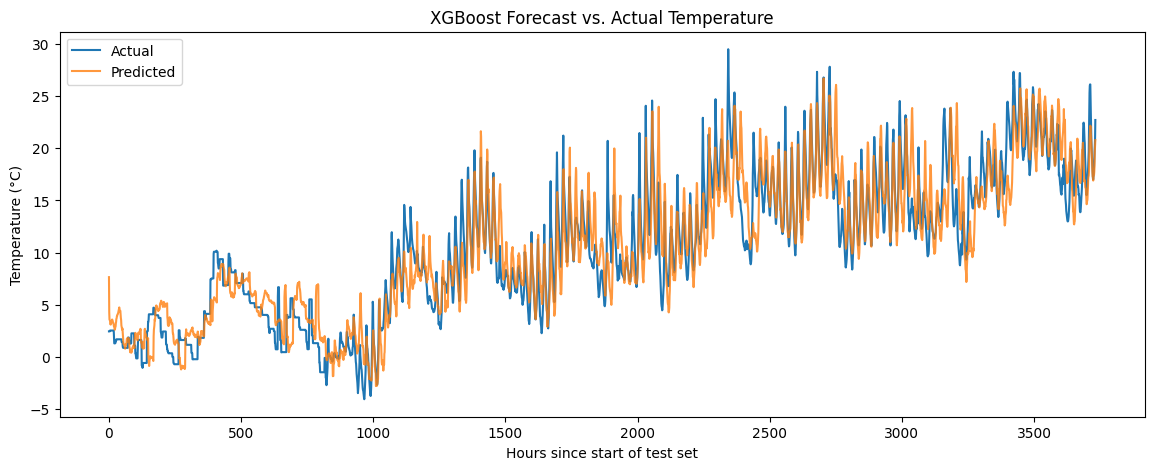

In [11]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred,         label="Predicted", alpha=0.8)
plt.title("XGBoost Forecast vs. Actual Temperature")
plt.xlabel("Hours since start of test set")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()